In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('KWSerpAnalysis 05 - Authority Labs Scrape 2019-09-12.csv')

In [3]:
print(list(df))
df = df[['query', 'result_type']]

['query', 'result_topic', 'result_type', 'domain', 'sub_domain', 'position', 'number_of_results', 'wtd_count', 'date', 'hour_of_day', 'scrape_geo', 'title', 'desc']


### Tag funnel types: informational, navigational, transactional by known keywords labels
- https://blog.alexa.com/how-to-optimize-for-three-types-of-buyer-keywords/

In [4]:
informational = ['how', 'what', 'benefit', 'way to', 'ways to', 'guide', 'how', 'tutorial', 'best', 'cheap',
                'alternatives', 'compare', 'improve', 'why']
navigational = ['location', 'near me', 'feature', 'cost', 'hour', 'direction', 'review', 'shipping', 
                'price', 'testimonial']
transactional = ['apply', 'buy', 'coupon', 'clearance', 'deal', 'discount', 'download', 'sale', 'order', 
                 'purchase', 'reserve', 'appointment', 'special', 'buy']

def question_query(x, quest_list):
    
    if any(word in x for word in quest_list):
        return 1
    else:
        return 0

df['informational'] = df['query'].apply(lambda x: question_query(x, informational))
df['navigational'] = df['query'].apply(lambda x: question_query(x, navigational))
df['transactional'] = df['query'].apply(lambda x: question_query(x, transactional))

df.loc[df['query'].str.contains('why')].head()

df['temp_calc'] = df['informational'] + df['navigational'] + df['transactional']
df = df[df['temp_calc'] == 1]

df['INT'] = None
df.loc[df.informational == 1, 'INT'] = 'informational'
df.loc[df.navigational == 1, 'INT'] = 'navigational'
df.loc[df.transactional == 1, 'INT'] = 'transactional'

df = df.drop(['informational', 'navigational', 'transactional', 'temp_calc'], axis=1)

df.INT.value_counts()

informational    68256
navigational     15891
transactional     7308
Name: INT, dtype: int64

In [5]:
df.head()

,query,result_type,INT
13,$2 colgate coupon,Organic,transactional
14,$2 colgate coupon,Organic,transactional
15,$2 colgate coupon,Organic,transactional
16,$2 colgate coupon,Organic,transactional
17,$2 colgate coupon,Organic,transactional


In [6]:
pd.crosstab(df.result_type, df.INT)

INT,informational,navigational,transactional
result_type,,,
Answer Box,4817,472,130
Image,21,81,31
Local Pack,228,282,78
News,27,8,1
Organic,46289,11005,5391
Organic & Sitelinks,4,46,10
Paid Search Ad,1326,379,284
People Also Ask,15467,3605,1378
Shopping Ad,8,0,0


In [7]:
df_new = df['query'].groupby([df['query'], df['INT'], df['result_type']]).count()
df_new = df_new.unstack()
df_new = df_new.fillna(0)
df_new.reset_index(inplace=True)
df_new['len'] = df_new['query'].str.split().apply(len)
df_new.head()

result_type,query,INT,Answer Box,Image,Local Pack,News,Organic,Organic & Sitelinks,Paid Search Ad,People Also Ask,Shopping Ad,Video,len
0,$2 colgate coupon,transactional,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,3
1,$2 off colgate coupon,transactional,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,4
2,10 ways to define leadership,informational,0.0,0.0,0.0,0.0,9.0,0.0,0.0,4.0,0.0,0.0,5
3,11 ways to change an organizational culture,informational,0.0,0.0,0.0,0.0,9.0,0.0,0.0,4.0,0.0,0.0,7
4,12 hour breath freshener,navigational,0.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0,4


In [8]:
df_new['INT'].value_counts()

informational    5662
navigational     1295
transactional     605
Name: INT, dtype: int64

### Undersample the classes

In [9]:
import random
random.seed(100)

len_all = df_new.shape[0]
len_i = df_new[df_new['INT'] == 'informational'].shape[0]
len_n = df_new[df_new['INT'] == 'navigational'].shape[0]
len_t = df_new[df_new['INT'] == 'transactional'].shape[0]

df_new.loc[df_new['INT'] == 'informational', 'random'] = np.random.uniform(0,1,len_i)
df_new.loc[df_new['INT'] == 'navigational', 'random'] = np.random.uniform(0,1,len_n)
df_new.loc[df_new['INT'] == 'transactional', 'random'] = 0

In [10]:
df_new = df_new.loc[~((df_new['INT'] == 'informational') & (df_new['random'] <= 1-(len_t/len_i)))]
df_new = df_new.loc[~((df_new['INT'] == 'navigational') & (df_new['random'] <= 1-(len_t/len_n)))]
df_new = df_new.drop(['random'], axis=1)

df_new['INT'].value_counts()

transactional    605
informational    593
navigational     583
Name: INT, dtype: int64

In [11]:
df_new.groupby('INT').agg('sum')

result_type,Answer Box,Image,Local Pack,News,Organic,Organic & Sitelinks,Paid Search Ad,People Also Ask,Shopping Ad,Video,len
INT,,,,,,,,,,,
informational,512.0,2.0,18.0,1.0,4849.0,0.0,134.0,1619.0,0.0,4.0,3611
navigational,201.0,41.0,141.0,4.0,4975.0,19.0,190.0,1601.0,0.0,1.0,2483
transactional,130.0,31.0,78.0,1.0,5391.0,10.0,284.0,1378.0,0.0,5.0,2391


## Modeling

### Sample split

In [12]:
X = df_new.drop(['query', 'INT'], axis=1)
y = df_new[['INT']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=234)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1424, 11) (1424, 1)
(357, 11) (357, 1)


### Train random forest and get predictions

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# random forest model creation
rfc = RandomForestClassifier(n_estimators=1000, max_features="sqrt", min_samples_split=2,
                             oob_score=True, random_state=100)
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Model evaluation

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = rfc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[85 15 18]
 [26 52 48]
 [16 27 70]]
               precision    recall  f1-score   support

informational       0.67      0.72      0.69       118
 navigational       0.55      0.41      0.47       126
transactional       0.51      0.62      0.56       113

     accuracy                           0.58       357
    macro avg       0.58      0.58      0.58       357
 weighted avg       0.58      0.58      0.57       357



### Feature Importance and Visualization

1. feature 10 (0.372929)
2. feature 0 (0.170494)
3. feature 7 (0.127702)
4. feature 4 (0.125494)
5. feature 6 (0.113167)
6. feature 2 (0.044304)
7. feature 1 (0.022853)
8. feature 5 (0.011359)
9. feature 9 (0.007392)
10. feature 3 (0.004306)
11. feature 8 (0.000000)


<BarContainer object of 11 artists>

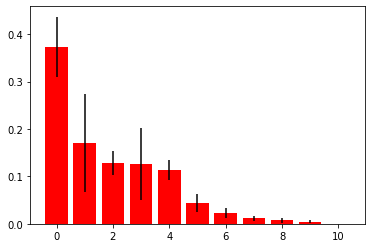

In [15]:
from matplotlib import pyplot as plt

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the rfc
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")

In [16]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False)

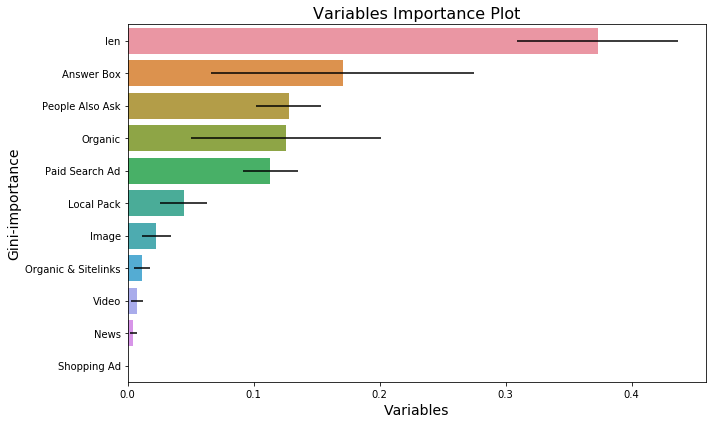

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

fig = sns.barplot(y=importances.index, x='Gini-importance', data=importances, ax=ax, xerr=std[indices])
ax.set_xlabel('Variables', fontsize=14)
ax.set_ylabel('Gini-importance', fontsize=14)
ax.set_title('Variables Importance Plot', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# df_new.to_csv('mkt funnel keywords for model.csv', index=False)